<a href="https://colab.research.google.com/github/patricktapajos/pos-ciencia-dados/blob/master/mod04-appv/aped_final_enem_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aquisição, Pré-processamento e Exploração de Dados - ENEM 2019**

# Apresentação



### Resumo
Este documento tem o objetivo de apresentar uma das etapas mais importantes do processo de análise de dados - a extração, transformação e carregamento dos dados ( conhecido como o ETL  - Extract, Transform and Load), cujo objetivo é permitir um melhor entendimento dos dados. 

O dataset escolhido apresenta uma amostra de dados do **Exame Nacional do Ensino Médio - o ENEM**, na sua edição do ano de 2019.



### Autores
Alunos de pós-graduação em Ciência de Dados da Universidade do Estado do Amazonas:
1.   [Patrick Tapajós Pinto](https://www.linkedin.com/in/patrick-tapajos-pinto/)
2.   [Wladimir Barroso Guedes de Araújo Neto](https://www.linkedin.com/in/wladneto/)


### Ferramentas Utilizadas
A análise será efetuada utilizando-se a linguagem de programação python e suas bibliotecas para análise e processamento de dados **Pandas** e **NumPy**, bem como as bibliotecas **Matplotlib** e **Seaborn** para visualização de dados.

# Sobre o ENEM

O Exame Nacional do Ensino Médio (Enem) é uma prova aplicada aos estudantes que estão prestes a concluir o Ensino Médio e avalia seu desempenho, colaborando para:

 - Acesso à educação superior: Sisu | Prouni | instituições portuguesas.
 - Acesso a financiamento e apoio estudantil: Fies | Prouni.
 - Autoavaliação
 - Desenvolvimento de estudos e indicadores educacionais.

### Questionário Socioeconômico
No momento da inscrição, o estudante preenche um questionário socioeconômico que tem por objetivo levantar informações que permitam caracterizar seu perfil e o contexto de seus processos formativos, relevantes para a compreensão dos resultados do participantes no Enem e para subsidiar os processos de avaliação de cursos de graduação e instituições de educação superior.

### Provas
São aplicadas 4 provas objetivas, com 45 questões cada:
 - Linguagens, códigos e suas tecnologias;
 - Ciências humanas e suas tecnologias;
 - Ciências da natureza e suas tecnologias; e
 - Matemática e suas tecnologias.

Além disso, o estudante deverá escrever uma redação - um texto dissertativo-argumentativo desenvolvido a partir de uma situação-problema, contendo no máximo 30 linhas.

Para mais informações, acesse: https://enem.inep.gov.br/antes#conheca-o-enem

# Coleta de Dados


Os dados foram disponibilizados pela plataforma de cursos **Alura** e contém cerca de 128 mil registros de inscrições de candidatos que realizaram as provas do ENEM 2019.
<br>
<br>
Link para download dos dados: https://github.com/alura-cursos/imersao-dados-2-2020/blob/master/MICRODADOS_ENEM_2019_SAMPLE_43278.csv?raw=true. 

# Questões Levantadas

O dataset do ENEM 2019 possui todas as informações acerca das notas dos alunos, do preenchimento do seu cartão-resposta, bem como as respostas do questionário socioeconômico. Este documento procura trabalhar na transformação deste dataset e seus dados para torná-lo mais propício a responder às seguintes questões:

 1. Qual a região que teve o melhor e o pior desempenho?
 2. Qual a faixa etária teve o melhor e o pior desempenho?
 3. Qual o quantitativo de pessoas que possui algum tipo de deficiência?
 4. Quem zerou uma prova faltou ou teve desempenho ruim?
 5. Há algum fator no questionário que tenha impactado na nota do candidato?


 Para entender a nomenclatura dos atributos do dataset, o INEP dispolibiliza um dicionário de dados: https://docs.google.com/spreadsheets/d/1_cVm4bGbTYrYONUqbQ4upuToqeZQ7G8x/edit#gid=1023919100.

# Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.cluster import KMeans
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_regression, f_classif

!pip install unidecode
from unidecode import unidecode

# Importação da biblioteca auxiliar do IGBE
!pip install ibge
from ibge.localidades import *

# Funções utilizadas

Função **print_df_info**: apresenta um resumo sobre alguns metadados do dataframe.

In [ ]:
def print_df_info(df):
  qtd_registros, qtd_atributos = df.shape
  atributos_categoricos = df.select_dtypes(exclude=['number']).columns
  atributos_numericos = df.select_dtypes(exclude=['object']).columns
  print("O dataset possui: ")
  print(" - %d registros" % qtd_registros)
  print(" - %d atributos" % qtd_atributos)
  print(" - %d atributos categóricos: %s" % (len(atributos_categoricos), atributos_categoricos))
  print(" - %d atributos numéricos: %s" % (len(atributos_numericos), atributos_numericos))

# Dicionários utilizados

In [ ]:
# Dicionário para discretização do atributo NU_IDADE
faixas = {
    0: 'Menor de 18',
    1: 'Entre 18 e 30',
    2: 'Entre 31 e 60',
    3: 'Maior que 60'
}

# Dicionário para transformação dos atributos relativos ao questionário
resposta_q = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5,
    'F':6,
    'G':7,
    'H':8,
    'I':9,
    'J':10,
    'K':11,
    'L':12,
    'M':13,
    'N':14,
    'O':15,
    'P':16,
    'Q':17
}

# Dicionário para discretização das informações relativas à presença do candidato na prova
presencas = {
    0: 'Nenhum dia',
    1: 'Somente dia 1',
    2: 'Somente dia 2',
    3: 'Todos os dias'
}


# Dicionário de regiões
regioes = {
    'Norte': 1,
    'Nordeste': 2,
    'Centro-Oeste': 3,
    'Sudeste': 4,
    'Sul': 5    
}

# ETL - Extração, Transformação e Carregamento

## Extração

Nesta etapa, verificamos nossa fonte de dados e fazemos a importação para o ambiente. EM nosso caso, só temos uma fonte - uma URL que contém os dados em formato csv.

In [ ]:
fonte = "https://github.com/alura-cursos/imersao-dados-2-2020/blob/master/MICRODADOS_ENEM_2019_SAMPLE_43278.csv?raw=true"

df_raw_enem = pd.read_csv(fonte)
df_raw_enem.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,1,1506138.0,Redenção,15.0,PA,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,ACAEAAACABEBABAADCEEEDE*CBDCCCADADCCCBEBBBBDB,99999CCCABBCAADDBCEBCCADBEEBDECBAABDEACACAEABB...,DEEDCAECDDEEECBCBECABEBAECBBCDAECAEBBBBBDCCDB,1,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,60.0,100.0,80.0,80.0,100.0,420.0,B,B,A,A,4,B,A,C,B,A,C,B,A,A,A,A,A,A,A,B,A,C,A,B,B
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,1,1504208.0,Marabá,15.0,PA,1,3,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,ABBCEADCEBAAACACEDCDCDACCCACDCBCABCAACBDBDEDE,99999ABCEBCEDDECEEEBBCCEECCABDABEEBCDEAEBBEAEA...,NaN,1,NaN,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,NaN,1.0,80.0,100.0,80.0,80.0,60.0,400.0,C,C,A,A,4,B,A,B,C,A,A,B,B,B,A,A,A,A,B,A,A,B,A,A,B
2,190001004722,2019,1501402,Belém,15,PA,35,F,2,1,1,1501402.0,Belém,15.0,PA,1,12,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,CDCAACCAAADEACBBEBAAEECDABDEBAEAABEDCABABAABC,99999ECBCECEBBABECCCECECCEECCDECEEEDADDDDECEDD...,DDBEADEBBCADCEEACABECBCEBADECADCEDAACBDABABCE,1,AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,EEEADBEBACABCDBABECECACDCBDCCEDCDABEDECDDDBAA,1.0,100.0,120.0,120.0,100.0,120.0,560.0,C,A,B,B,5,C,A,B,C,A,A,B,A,B,A,A,A,A,B,A,B,B,A,A,B
3,190001004735,2019,1507300,São Félix do Xingu,15,PA,23,F,1,3,1,1505437.0,Ourilândia do Norte,15.0,PA,1,7,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,EECCCEDBADBEAAAAEBAECEAAAAEEEBACCAC*CEAEDAECE,99999BABCDABBCBDDAAECADBDDADDCBCEEDCAEBCEAEABD...,CBDEBBCBDEBCABCDBDEDADCCBEDBCAECEBEBDEBAEECBC,1,BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,BEDEEEAADBEBACABCDBABECECACADCBDCCEDCDABECDDD,1.0,100.0,120.0,120.0,120.0,40.0,500.0,E,C,A,A,1,B,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,B
4,190001004776,2019,1500800,Ananindeua,15,PA,16,F,1,3,1,1500800.0,Ananindeua,15.0,PA,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,CCBCBEACABACABBBBACCBCEBDCBABCADADCBCADBAADEA,EBCAB99999BBCECBCACBEACBDAABDBCBBDACEBBACDCAEC...,AECCBBCBBCBDEDECACBAABEDABBEDDADCEADDBEBDBBEB,0,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,160.0,140.0,160.0,160.0,160.0,780.0,E,E,B,D,3,E,A,B,C,B,A,B,A,A,A,A,A,A,B,A,A,D,A,A,B


Vamos visualizar algumas informações deste dataset

In [ ]:
df_raw_enem.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127380 entries, 0 to 127379
Data columns (total 136 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NU_INSCRICAO                 127380 non-null  int64  
 1   NU_ANO                       127380 non-null  int64  
 2   CO_MUNICIPIO_RESIDENCIA      127380 non-null  int64  
 3   NO_MUNICIPIO_RESIDENCIA      127380 non-null  object 
 4   CO_UF_RESIDENCIA             127380 non-null  int64  
 5   SG_UF_RESIDENCIA             127380 non-null  object 
 6   NU_IDADE                     127380 non-null  int64  
 7   TP_SEXO                      127380 non-null  object 
 8   TP_ESTADO_CIVIL              127380 non-null  int64  
 9   TP_COR_RACA                  127380 non-null  int64  
 10  TP_NACIONALIDADE             127380 non-null  int64  
 11  CO_MUNICIPIO_NASCIMENTO      123757 non-null  float64
 12  NO_MUNICIPIO_NASCIMENTO      123757 non-null  object 
 13

Do total de 134 atributos, vamos utilizar os quais irão nos auxiliar a alcançar nosso objetivo. Vamos agrupá-los em listas, para facilitar o entendimento.

In [ ]:
atributos = ['NU_INSCRICAO','NU_ANO','NO_MUNICIPIO_PROVA','SG_UF_RESIDENCIA','TP_ESTADO_CIVIL','TP_COR_RACA','TP_NACIONALIDADE',
             'TP_LINGUA','TP_ESCOLA','NU_IDADE','TP_SEXO', 'IN_TREINEIRO']  

presenca =  ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']

deficiencia = ['IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DEFICIENCIA_AUDITIVA','IN_SURDO_CEGUEIRA','IN_DEFICIENCIA_FISICA','IN_DEFICIENCIA_MENTAL',
               'IN_DEFICIT_ATENCAO','IN_DISLEXIA','IN_DISCALCULIA','IN_AUTISMO','IN_VISAO_MONOCULAR']

notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

questionario = ['Q001','Q002','Q003','Q004','Q005','Q006','Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019','Q020',
                'Q021','Q022','Q023','Q024','Q025']

all_atributos = atributos + presenca + deficiencia + notas
df_enem = df_raw_enem[all_atributos]
print_df_info(df_enem)
df_enem.describe()

O dataset possui: 
 - 127380 registros
 - 33 atributos
 - 3 atributos categóricos: Index(['NO_MUNICIPIO_PROVA', 'SG_UF_RESIDENCIA', 'TP_SEXO'], dtype='object')
 - 30 atributos numéricos: Index(['NU_INSCRICAO', 'NU_ANO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_LINGUA', 'TP_ESCOLA', 'NU_IDADE',
       'IN_TREINEIRO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA',
       'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'],
      dtype='object')


,NU_INSCRICAO,NU_ANO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,NU_IDADE,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,1.273800e+05,127380.0,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,127380.000000,92758.000000,98043.000000,98043.000000,92758.000000,98043.000000
mean,1.900035e+11,2019.0,1.076841,2.131198,1.029345,0.524486,1.330515,22.094355,0.120906,0.729016,0.771667,0.771667,0.729016,0.001099,0.000110,0.000259,0.000377,0.000008,0.001499,0.000479,0.001704,0.000353,0.000055,0.000228,0.000228,477.964015,507.365912,520.463928,523.555206,571.570025
std,1.469535e+06,0.0,0.440671,1.017373,0.202790,0.499402,0.555043,7.498707,0.326019,0.445387,0.422110,0.422110,0.445387,0.033134,0.010483,0.016094,0.019408,0.002802,0.038694,0.021878,0.041239,0.018792,0.007413,0.015087,0.015087,76.296099,82.972839,64.556578,109.416939,188.076455
min,1.900010e+11,2019.0,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.900023e+11,2019.0,1.000000,1.000000,1.000000,0.000000,1.000000,18.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,418.000000,447.900000,483.700000,435.300000,480.000000
50%,1.900035e+11,2019.0,1.000000,2.000000,1.000000,1.000000,1.000000,19.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,470.200000,510.900000,526.100000,501.600000,580.000000
75%,1.900048e+11,2019.0,1.000000,3.000000,1.000000,1.000000,2.000000,24.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,533.300000,567.100000,565.100000,598.200000,680.000000
max,1.900061e+11,2019.0,4.000000,5.000000,4.000000,1.000000,3.000000,82.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,797.300000,809.400000,801.700000,985.000000,1000.000000


## Transformação

### Discretização

Um dos processos que podem ser utilizados para tratar os dados é a discretização, ou seja, a tranformação dos valores de variáveis contínuas em valores discretos, que possuam um intervalo finito, para melhor compreensão e análise.


#### PcD

Neste dataset, isso já ocorre com a informação acerca da deficiência do candidato. Porém, nosso objetivo é apenas saber se o candidato possui alguma deficiência, independente de qual seja.

Para isso, vamos efetuar o processo inverso da discretização: vamos transformar os atributos que informam a deficiência do candidato em uma única coluna - a qual apenas informará se o mesmo é pcd (pessoa com deficiência) ou não.

Verificaremos quem assinalou que possui alguma deficiência

In [ ]:
# Verificando quem possui alguma deficiência

# Adicionando o campo de inscrição de valor único para ser o índice neste dataset e auxiliar no merge posteriormente
campos_pcd = deficiencia + ['NU_INSCRICAO']
df_pcd = df_enem[campos_pcd]
df_pcd.set_index('NU_INSCRICAO',inplace=True)
df_pcd = df_pcd[df_pcd==1].stack().reset_index().drop(0,1)
df_pcd.rename(columns={'level_1':'TP_PCD'}, inplace=True)
df_pcd.drop_duplicates('NU_INSCRICAO', inplace=True)
df_pcd

,NU_INSCRICAO,TP_PCD
0,190001012181,IN_DEFICIENCIA_FISICA
1,190001020083,IN_DEFICIENCIA_FISICA
2,190001021060,IN_SURDEZ
3,190001043627,IN_DEFICIENCIA_FISICA
4,190001055170,IN_DEFICIENCIA_FISICA
...,...,...
810,190006063178,IN_SURDEZ
811,190006079969,IN_DEFICIT_ATENCAO
812,190006080894,IN_DEFICIENCIA_FISICA
813,190006082323,IN_DEFICIENCIA_MENTAL


Agora vamos gerar um novo dataframe, gerado a partir da mesclagem do dataframe de candidatos que informaram que possuem alguma deficiência com o dataframe geral, efetuando essa junção por meio da informação chave **NU_INSCRICAO**.

In [ ]:
# Merge dos dataframes
new_df_enem = pd.merge(df_enem, df_pcd, how='left', on='NU_INSCRICAO')
new_df_enem

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,NU_IDADE,TP_SEXO,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD
0,190001004661,2019,Redenção,PA,1,3,1,1,1,17,M,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,435.6,512.3,488.6,432.4,420.0,NaN
1,190001004674,2019,Marabá,PA,1,3,1,1,1,23,M,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,409.3,375.3,NaN,400.0,NaN
2,190001004722,2019,Belém,PA,2,1,1,1,1,35,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,423.2,499.1,441.0,427.2,560.0,NaN
3,190001004735,2019,São Félix do Xingu,PA,1,3,1,1,1,23,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,426.2,578.1,551.5,499.9,500.0,NaN
4,190001004776,2019,Ananindeua,PA,1,3,1,0,1,16,F,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,516.5,571.3,511.2,424.5,780.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,Cocos,MG,1,1,1,1,2,17,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,502.4,559.6,525.7,539.7,740.0,NaN
127376,190006120036,2019,Barra da Estiva,BA,1,2,1,0,2,18,M,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,449.1,380.9,450.3,418.2,520.0,NaN
127377,190006120037,2019,Salvador,BA,1,3,1,1,1,22,F,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,516.0,497.9,NaN,440.0,NaN
127378,190006120060,2019,Simões Filho,BA,2,2,1,1,1,26,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,564.7,416.2,517.3,455.7,620.0,NaN


#### Faixa de Idade

Com relação à faixa de idade, podemos aplicar a discretização para agrupar os dados por faixas etárias. Iremos utilizar uma função do próprio pandas chamada **cut**.

In [ ]:
df_faixas_etarias = new_df_enem.copy()
bins= [0, 18, 31, 61, 150]
labels = faixas.keys()
df_faixas_etarias['TP_FAIXA_ETARIA'] = pd.cut(df_faixas_etarias['NU_IDADE'], bins=bins, labels=labels, right=False)
df_faixas_etarias

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,NU_IDADE,TP_SEXO,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA
0,190001004661,2019,Redenção,PA,1,3,1,1,1,17,M,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,435.6,512.3,488.6,432.4,420.0,NaN,0
1,190001004674,2019,Marabá,PA,1,3,1,1,1,23,M,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,409.3,375.3,NaN,400.0,NaN,1
2,190001004722,2019,Belém,PA,2,1,1,1,1,35,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,423.2,499.1,441.0,427.2,560.0,NaN,2
3,190001004735,2019,São Félix do Xingu,PA,1,3,1,1,1,23,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,426.2,578.1,551.5,499.9,500.0,NaN,1
4,190001004776,2019,Ananindeua,PA,1,3,1,0,1,16,F,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,516.5,571.3,511.2,424.5,780.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,Cocos,MG,1,1,1,1,2,17,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,502.4,559.6,525.7,539.7,740.0,NaN,0
127376,190006120036,2019,Barra da Estiva,BA,1,2,1,0,2,18,M,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,449.1,380.9,450.3,418.2,520.0,NaN,1
127377,190006120037,2019,Salvador,BA,1,3,1,1,1,22,F,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,516.0,497.9,NaN,440.0,NaN,1
127378,190006120060,2019,Simões Filho,BA,2,2,1,1,1,26,F,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,564.7,416.2,517.3,455.7,620.0,NaN,1


#### Sexo

Sexo possui valores 'M' para masculino e 'F' para feminino. Vamos torná-los numéricos.

In [ ]:
df_sexo = df_faixas_etarias.copy()

df_sexo['TP_SEXO'] = df_sexo['TP_SEXO'].apply(lambda s: 0 if s=='M' else 0)
df_sexo

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,NU_IDADE,TP_SEXO,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA
0,190001004661,2019,Redenção,PA,1,3,1,1,1,17,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,435.6,512.3,488.6,432.4,420.0,NaN,0
1,190001004674,2019,Marabá,PA,1,3,1,1,1,23,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,409.3,375.3,NaN,400.0,NaN,1
2,190001004722,2019,Belém,PA,2,1,1,1,1,35,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,423.2,499.1,441.0,427.2,560.0,NaN,2
3,190001004735,2019,São Félix do Xingu,PA,1,3,1,1,1,23,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,426.2,578.1,551.5,499.9,500.0,NaN,1
4,190001004776,2019,Ananindeua,PA,1,3,1,0,1,16,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,516.5,571.3,511.2,424.5,780.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,Cocos,MG,1,1,1,1,2,17,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,502.4,559.6,525.7,539.7,740.0,NaN,0
127376,190006120036,2019,Barra da Estiva,BA,1,2,1,0,2,18,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,449.1,380.9,450.3,418.2,520.0,NaN,1
127377,190006120037,2019,Salvador,BA,1,3,1,1,1,22,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,516.0,497.9,NaN,440.0,NaN,1
127378,190006120060,2019,Simões Filho,BA,2,2,1,1,1,26,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,564.7,416.2,517.3,455.7,620.0,NaN,1


#### Presença na prova

As provas são realizadas em dois dias. Em um dia são aplicadas as provas de
Linguagens, Códigos e suas Tecnologias, Redação e Ciências Humanas e suas Tecnologias. No outro dia são aplicadas as provas de Ciências da Natureza e suas Tecnologias e Matemática e suas Tecnologias.

Nos interessa saber se os alunos compareceram nos dois dias ou, caso contrário, qual dia houve mais faltas.

In [ ]:
df_zerou_faltou = df_sexo.copy()

def calc_nota(a, b, c, d, e):
  return (a + b + c + d + e)
  
def verifica_presenca(df):
  if(df['TP_PRESENCA_CH'] == df['TP_PRESENCA_CN'] == 0):
    return 0
  elif(df['TP_PRESENCA_CH'] == 1 and df['TP_PRESENCA_CN'] == 0):
    return 1
  elif(df['TP_PRESENCA_CH'] == 0 and df['TP_PRESENCA_CN'] == 1):
    return 2
  else:
    return 3 


# df_zerou_faltou['NOTA_ENEM'] = df_zerou_faltou.apply(lambda row : calc_nota(row['NU_NOTA_CN'], 
#                      row['NU_NOTA_CH'], row['NU_NOTA_LC'], row['NU_NOTA_MT'], 
#                      row['NU_NOTA_REDACAO']), axis = 1)

df_zerou_faltou['TP_PRESENCA'] = df_zerou_faltou.apply(lambda row: verifica_presenca(row), axis=1)
df_zerou_faltou

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,NU_IDADE,TP_SEXO,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA
0,190001004661,2019,Redenção,PA,1,3,1,1,1,17,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,435.6,512.3,488.6,432.4,420.0,NaN,0,3
1,190001004674,2019,Marabá,PA,1,3,1,1,1,23,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,409.3,375.3,NaN,400.0,NaN,1,1
2,190001004722,2019,Belém,PA,2,1,1,1,1,35,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,423.2,499.1,441.0,427.2,560.0,NaN,2,3
3,190001004735,2019,São Félix do Xingu,PA,1,3,1,1,1,23,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,426.2,578.1,551.5,499.9,500.0,NaN,1,3
4,190001004776,2019,Ananindeua,PA,1,3,1,0,1,16,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,516.5,571.3,511.2,424.5,780.0,NaN,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,Cocos,MG,1,1,1,1,2,17,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,502.4,559.6,525.7,539.7,740.0,NaN,0,3
127376,190006120036,2019,Barra da Estiva,BA,1,2,1,0,2,18,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,449.1,380.9,450.3,418.2,520.0,NaN,1,3
127377,190006120037,2019,Salvador,BA,1,3,1,1,1,22,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,516.0,497.9,NaN,440.0,NaN,1,1
127378,190006120060,2019,Simões Filho,BA,2,2,1,1,1,26,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,564.7,416.2,517.3,455.7,620.0,NaN,1,3


#### Região

Uma questão levantada neste documento é sobre a região dos candidatos. O dataset possui a informação sobre o município e o estado no qual a prova foi realizada.

Como não temos a informação sobre a região, vamos utilizar a API do IBGE para nos ajudar a descobrir!

In [ ]:
df_regiao = df_zerou_faltou.copy()

# Dicionário contendo as informações do estado - IBGE
estados_dict = {unidecode(estado['sigla']).lower(): estado for estado in Estados().json()}

# Método que atribui a região à um registro conforme o estado
def getRegiao(estado):
  estado = estado.lower()
  if estado in estados_dict.keys():
    return regioes[f"{estados_dict[estado]['regiao']['nome']}"]
  else:
    return 0

# Criação da nova coluna com seus valores
df_regiao['TP_REGIAO'] = [getRegiao(estado) for estado in df_regiao['SG_UF_RESIDENCIA']]
df_regiao

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,NU_IDADE,TP_SEXO,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO
0,190001004661,2019,Redenção,PA,1,3,1,1,1,17,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,435.6,512.3,488.6,432.4,420.0,NaN,0,3,1
1,190001004674,2019,Marabá,PA,1,3,1,1,1,23,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,409.3,375.3,NaN,400.0,NaN,1,1,1
2,190001004722,2019,Belém,PA,2,1,1,1,1,35,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,423.2,499.1,441.0,427.2,560.0,NaN,2,3,1
3,190001004735,2019,São Félix do Xingu,PA,1,3,1,1,1,23,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,426.2,578.1,551.5,499.9,500.0,NaN,1,3,1
4,190001004776,2019,Ananindeua,PA,1,3,1,0,1,16,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,516.5,571.3,511.2,424.5,780.0,NaN,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,Cocos,MG,1,1,1,1,2,17,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,502.4,559.6,525.7,539.7,740.0,NaN,0,3,4
127376,190006120036,2019,Barra da Estiva,BA,1,2,1,0,2,18,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,449.1,380.9,450.3,418.2,520.0,NaN,1,3,2
127377,190006120037,2019,Salvador,BA,1,3,1,1,1,22,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,516.0,497.9,NaN,440.0,NaN,1,1,2
127378,190006120060,2019,Simões Filho,BA,2,2,1,1,1,26,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,564.7,416.2,517.3,455.7,620.0,NaN,1,3,2


#### Questionário socioeconômico

In [ ]:
df_qs = df_raw_enem[questionario]
df_qs.replace(resposta_q, inplace=True)
df_qs

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,2,2,1,1,4,2,1,3,2,1,3,2,1,1,1,1,1,1,1,2,1,3,1,2,2
1,3,3,1,1,4,2,1,2,3,1,1,2,2,2,1,1,1,1,2,1,1,2,1,1,2
2,3,1,2,2,5,3,1,2,3,1,1,2,1,2,1,1,1,1,2,1,2,2,1,1,2
3,5,3,1,1,1,2,1,2,3,1,1,2,1,1,1,1,1,1,2,1,1,2,1,1,2
4,5,5,2,4,3,5,1,2,3,2,1,2,1,1,1,1,1,1,2,1,1,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,4,6,1,4,3,7,1,3,3,1,1,2,2,1,1,1,1,1,2,1,1,4,1,2,2
127376,5,3,1,2,4,2,1,2,3,1,2,2,1,1,1,1,1,1,2,1,1,4,1,2,2
127377,8,5,6,2,1,2,1,2,2,1,1,2,1,1,1,1,1,1,1,1,1,2,1,1,2
127378,5,5,3,2,2,3,1,2,2,1,1,2,1,1,1,1,1,1,2,1,1,3,1,1,1


In [ ]:
df_ds = df_regiao.join(df_qs)
df_ds

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,NU_IDADE,TP_SEXO,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004661,2019,Redenção,PA,1,3,1,1,1,17,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,435.6,512.3,488.6,432.4,420.0,NaN,0,3,1,2,2,1,1,4,2,1,3,2,1,3,2,1,1,1,1,1,1,1,2,1,3,1,2,2
1,190001004674,2019,Marabá,PA,1,3,1,1,1,23,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,409.3,375.3,NaN,400.0,NaN,1,1,1,3,3,1,1,4,2,1,2,3,1,1,2,2,2,1,1,1,1,2,1,1,2,1,1,2
2,190001004722,2019,Belém,PA,2,1,1,1,1,35,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,423.2,499.1,441.0,427.2,560.0,NaN,2,3,1,3,1,2,2,5,3,1,2,3,1,1,2,1,2,1,1,1,1,2,1,2,2,1,1,2
3,190001004735,2019,São Félix do Xingu,PA,1,3,1,1,1,23,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,426.2,578.1,551.5,499.9,500.0,NaN,1,3,1,5,3,1,1,1,2,1,2,3,1,1,2,1,1,1,1,1,1,2,1,1,2,1,1,2
4,190001004776,2019,Ananindeua,PA,1,3,1,0,1,16,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,516.5,571.3,511.2,424.5,780.0,NaN,0,3,1,5,5,2,4,3,5,1,2,3,2,1,2,1,1,1,1,1,1,2,1,1,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,Cocos,MG,1,1,1,1,2,17,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,502.4,559.6,525.7,539.7,740.0,NaN,0,3,4,4,6,1,4,3,7,1,3,3,1,1,2,2,1,1,1,1,1,2,1,1,4,1,2,2
127376,190006120036,2019,Barra da Estiva,BA,1,2,1,0,2,18,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,449.1,380.9,450.3,418.2,520.0,NaN,1,3,2,5,3,1,2,4,2,1,2,3,1,2,2,1,1,1,1,1,1,2,1,1,4,1,2,2
127377,190006120037,2019,Salvador,BA,1,3,1,1,1,22,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,516.0,497.9,NaN,440.0,NaN,1,1,2,8,5,6,2,1,2,1,2,2,1,1,2,1,1,1,1,1,1,1,1,1,2,1,1,2
127378,190006120060,2019,Simões Filho,BA,2,2,1,1,1,26,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,564.7,416.2,517.3,455.7,620.0,NaN,1,3,2,5,5,3,2,2,3,1,2,2,1,1,2,1,1,1,1,1,1,2,1,1,3,1,1,1


### Limpeza

A limpeza é um processo onde verifica-se no dataset valores faltantes, fora do domínio, com acentuação errada, etc, dados inconsistentes e que podem impactar na análise e na aplicação de modelos de ML.

O que fazer com estes dados?

In [ ]:
df_ds.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127380 entries, 0 to 127379
Data columns (total 62 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   NU_INSCRICAO             127380 non-null  int64   
 1   NU_ANO                   127380 non-null  int64   
 2   NO_MUNICIPIO_PROVA       127380 non-null  object  
 3   SG_UF_RESIDENCIA         127380 non-null  object  
 4   TP_ESTADO_CIVIL          127380 non-null  int64   
 5   TP_COR_RACA              127380 non-null  int64   
 6   TP_NACIONALIDADE         127380 non-null  int64   
 7   TP_LINGUA                127380 non-null  int64   
 8   TP_ESCOLA                127380 non-null  int64   
 9   NU_IDADE                 127380 non-null  int64   
 10  TP_SEXO                  127380 non-null  int64   
 11  IN_TREINEIRO             127380 non-null  int64   
 12  TP_PRESENCA_CN           127380 non-null  int64   
 13  TP_PRESENCA_CH           127380 non-null  in

In [ ]:

# Retirando campos do dataframe relacionados às informações das deficiências
df_ds.drop(deficiencia, axis=1, inplace=True)

# Retirando campos relativos à presença nas provas, pois discretizamos seu valor
df_ds.drop(presenca, inplace=True, axis=1)

# Retirando campo relativo à idade, pois discretizamos seu valor
df_ds.drop(['NU_IDADE'], inplace=True, axis=1)

# Atribuindo 0 para os dados da nova coluna 'TP_PCD' que possuem valor NaN
df_ds['TP_PCD'] = df_ds['TP_PCD'].apply(lambda p: 0 if(pd.isna(p)) else 1)

# Atribuindo valor 0 para notas não existentes
df_ds.fillna(0, inplace=True)



In [ ]:
df_ds

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,TP_SEXO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004661,2019,Redenção,PA,1,3,1,1,1,0,1,435.6,512.3,488.6,432.4,420.0,0,0,3,1,2,2,1,1,4,2,1,3,2,1,3,2,1,1,1,1,1,1,1,2,1,3,1,2,2
1,190001004674,2019,Marabá,PA,1,3,1,1,1,0,0,0.0,409.3,375.3,0.0,400.0,0,1,1,1,3,3,1,1,4,2,1,2,3,1,1,2,2,2,1,1,1,1,2,1,1,2,1,1,2
2,190001004722,2019,Belém,PA,2,1,1,1,1,0,0,423.2,499.1,441.0,427.2,560.0,0,2,3,1,3,1,2,2,5,3,1,2,3,1,1,2,1,2,1,1,1,1,2,1,2,2,1,1,2
3,190001004735,2019,São Félix do Xingu,PA,1,3,1,1,1,0,0,426.2,578.1,551.5,499.9,500.0,0,1,3,1,5,3,1,1,1,2,1,2,3,1,1,2,1,1,1,1,1,1,2,1,1,2,1,1,2
4,190001004776,2019,Ananindeua,PA,1,3,1,0,1,0,1,516.5,571.3,511.2,424.5,780.0,0,0,3,1,5,5,2,4,3,5,1,2,3,2,1,2,1,1,1,1,1,1,2,1,1,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,Cocos,MG,1,1,1,1,2,0,0,502.4,559.6,525.7,539.7,740.0,0,0,3,4,4,6,1,4,3,7,1,3,3,1,1,2,2,1,1,1,1,1,2,1,1,4,1,2,2
127376,190006120036,2019,Barra da Estiva,BA,1,2,1,0,2,0,0,449.1,380.9,450.3,418.2,520.0,0,1,3,2,5,3,1,2,4,2,1,2,3,1,2,2,1,1,1,1,1,1,2,1,1,4,1,2,2
127377,190006120037,2019,Salvador,BA,1,3,1,1,1,0,0,0.0,516.0,497.9,0.0,440.0,0,1,1,2,8,5,6,2,1,2,1,2,2,1,1,2,1,1,1,1,1,1,1,1,1,2,1,1,2
127378,190006120060,2019,Simões Filho,BA,2,2,1,1,1,0,0,564.7,416.2,517.3,455.7,620.0,0,1,3,2,5,5,3,2,2,3,1,2,2,1,1,2,1,1,1,1,1,1,2,1,1,3,1,1,1


### Normalização

A normalização é um processo no qual os valores das variáveis numéricas são transformadas para que possuam uma escala comum, sem distorcer diferenças nos intervalos de valores ou perda de informações. A normalização também é necessária para alguns algoritmos para modelar os dados corretamente.

Vamos verificar quais os atributos numéricos de nosso dataset até o momento.

In [ ]:
print_df_info(df_ds)

O dataset possui: 
 - 127380 registros
 - 45 atributos
 - 3 atributos categóricos: Index(['NO_MUNICIPIO_PROVA', 'SG_UF_RESIDENCIA', 'TP_FAIXA_ETARIA'], dtype='object')
 - 43 atributos numéricos: Index(['NU_INSCRICAO', 'NU_ANO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_LINGUA', 'TP_ESCOLA', 'TP_SEXO', 'IN_TREINEIRO',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'TP_PCD', 'TP_FAIXA_ETARIA', 'TP_PRESENCA',
       'TP_REGIAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007',
       'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')


Temos 43 atributos numéricos. Vamos criar um dataframe utilizando somente estes atributos.

In [ ]:
atributos_numericos = ['NU_INSCRICAO', 'NU_ANO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_LINGUA', 'TP_ESCOLA', 'TP_SEXO', 'IN_TREINEIRO',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'TP_PCD', 'TP_FAIXA_ETARIA', 'TP_PRESENCA',
       'TP_REGIAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007',
       'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']

df_enem_numericos = df_ds[atributos_numericos]
df_enem_numericos

,NU_INSCRICAO,NU_ANO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,TP_SEXO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004661,2019,1,3,1,1,1,0,1,435.6,512.3,488.6,432.4,420.0,0,0,3,1,2,2,1,1,4,2,1,3,2,1,3,2,1,1,1,1,1,1,1,2,1,3,1,2,2
1,190001004674,2019,1,3,1,1,1,0,0,0.0,409.3,375.3,0.0,400.0,0,1,1,1,3,3,1,1,4,2,1,2,3,1,1,2,2,2,1,1,1,1,2,1,1,2,1,1,2
2,190001004722,2019,2,1,1,1,1,0,0,423.2,499.1,441.0,427.2,560.0,0,2,3,1,3,1,2,2,5,3,1,2,3,1,1,2,1,2,1,1,1,1,2,1,2,2,1,1,2
3,190001004735,2019,1,3,1,1,1,0,0,426.2,578.1,551.5,499.9,500.0,0,1,3,1,5,3,1,1,1,2,1,2,3,1,1,2,1,1,1,1,1,1,2,1,1,2,1,1,2
4,190001004776,2019,1,3,1,0,1,0,1,516.5,571.3,511.2,424.5,780.0,0,0,3,1,5,5,2,4,3,5,1,2,3,2,1,2,1,1,1,1,1,1,2,1,1,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,190006120035,2019,1,1,1,1,2,0,0,502.4,559.6,525.7,539.7,740.0,0,0,3,4,4,6,1,4,3,7,1,3,3,1,1,2,2,1,1,1,1,1,2,1,1,4,1,2,2
127376,190006120036,2019,1,2,1,0,2,0,0,449.1,380.9,450.3,418.2,520.0,0,1,3,2,5,3,1,2,4,2,1,2,3,1,2,2,1,1,1,1,1,1,2,1,1,4,1,2,2
127377,190006120037,2019,1,3,1,1,1,0,0,0.0,516.0,497.9,0.0,440.0,0,1,1,2,8,5,6,2,1,2,1,2,2,1,1,2,1,1,1,1,1,1,1,1,1,2,1,1,2
127378,190006120060,2019,2,2,1,1,1,0,0,564.7,416.2,517.3,455.7,620.0,0,1,3,2,5,5,3,2,2,3,1,2,2,1,1,2,1,1,1,1,1,1,2,1,1,3,1,1,1


In [ ]:
# def calc_nota(a, b, c, d, e):
#   return (a + b + c + d + e)/5

def calc_nota(a, b, c, d, e):
  return (a + b + c + d + e)
  
df_enem_numericos['NOTA_ENEM'] = df_ds.apply(lambda row : calc_nota(row['NU_NOTA_CN'], 
                     row['NU_NOTA_CH'], row['NU_NOTA_LC'], row['NU_NOTA_MT'], 
                     row['NU_NOTA_REDACAO']), axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Tudo certo, vamos normalizar. Podem ser utilizados vários métodos para esta normalização. A utilizada aqui será por meio da biblioteca **scikit**, método **MinMaxScaler**, o qual trasnforma os dados para eles estejam em uma faixa de valores entre 0 e 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
df_norm = pd.DataFrame(scaler.fit_transform(df_enem_numericos), columns=df_enem_numericos.columns)
df_norm

,NU_INSCRICAO,NU_ANO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,TP_SEXO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NOTA_ENEM
0,0.000000,0.0,0.25,0.6,0.25,1.0,0.0,0.0,1.0,0.546344,0.632938,0.609455,0.438985,0.42,0.0,0.000000,1.000000,0.00,0.142857,0.142857,0.0,0.0,0.157895,0.0625,0.0,0.50,0.25,0.00,0.50,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.0,0.0,0.50,0.0,0.25,1.0,0.549675
1,0.000003,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.505683,0.468130,0.000000,0.40,0.0,0.333333,0.333333,0.00,0.285714,0.285714,0.0,0.0,0.157895,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.25,0.25,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.284479
2,0.000012,0.0,0.50,0.2,0.25,1.0,0.0,0.0,0.0,0.530791,0.616630,0.550081,0.433706,0.56,0.0,0.666667,1.000000,0.00,0.285714,0.000000,0.2,0.2,0.210526,0.1250,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.25,0.00,0.0,0.0,0.0,0.25,0.0,1.0,0.25,0.0,0.00,1.0,0.564468
3,0.000014,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.534554,0.714233,0.687913,0.507513,0.50,0.0,0.333333,1.000000,0.00,0.571429,0.285714,0.0,0.0,0.000000,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.613746
4,0.000022,0.0,0.25,0.6,0.25,0.0,0.0,0.0,1.0,0.647811,0.705831,0.637645,0.430964,0.78,0.0,0.000000,1.000000,0.00,0.571429,0.571429,0.2,0.6,0.105263,0.2500,0.0,0.25,0.50,0.25,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.00,1.0,0.673255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,0.999974,0.0,0.25,0.2,0.25,1.0,0.5,0.0,0.0,0.630127,0.691376,0.655732,0.547919,0.74,0.0,0.000000,1.000000,0.75,0.428571,0.714286,0.0,0.6,0.105263,0.3750,0.0,0.50,0.50,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.688600
127376,0.999974,0.0,0.25,0.4,0.25,0.0,0.5,0.0,0.0,0.563276,0.470596,0.561681,0.424569,0.52,0.0,0.333333,1.000000,0.25,0.571429,0.285714,0.0,0.2,0.157895,0.0625,0.0,0.25,0.50,0.00,0.25,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.532768
127377,0.999974,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.637509,0.621055,0.000000,0.44,0.0,0.333333,0.333333,0.25,1.000000,0.571429,1.0,0.2,0.000000,0.0625,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.25,0.0,0.00,1.0,0.349151
127378,0.999978,0.0,0.50,0.4,0.25,1.0,0.0,0.0,0.0,0.708265,0.514208,0.645254,0.462640,0.62,0.0,0.333333,1.000000,0.25,0.571429,0.571429,0.4,0.2,0.052632,0.1250,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0,0.618117


### Seleção de atributos

#### Identificando e removendo variáveis com significância zero

In [ ]:
zero_sig = df_norm.copy()
zero_sig

,NU_INSCRICAO,NU_ANO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,TP_SEXO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NOTA_ENEM
0,0.000000,0.0,0.25,0.6,0.25,1.0,0.0,0.0,1.0,0.546344,0.632938,0.609455,0.438985,0.42,0.0,0.000000,1.000000,0.00,0.142857,0.142857,0.0,0.0,0.157895,0.0625,0.0,0.50,0.25,0.00,0.50,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.0,0.0,0.50,0.0,0.25,1.0,0.549675
1,0.000003,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.505683,0.468130,0.000000,0.40,0.0,0.333333,0.333333,0.00,0.285714,0.285714,0.0,0.0,0.157895,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.25,0.25,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.284479
2,0.000012,0.0,0.50,0.2,0.25,1.0,0.0,0.0,0.0,0.530791,0.616630,0.550081,0.433706,0.56,0.0,0.666667,1.000000,0.00,0.285714,0.000000,0.2,0.2,0.210526,0.1250,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.25,0.00,0.0,0.0,0.0,0.25,0.0,1.0,0.25,0.0,0.00,1.0,0.564468
3,0.000014,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.534554,0.714233,0.687913,0.507513,0.50,0.0,0.333333,1.000000,0.00,0.571429,0.285714,0.0,0.0,0.000000,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.613746
4,0.000022,0.0,0.25,0.6,0.25,0.0,0.0,0.0,1.0,0.647811,0.705831,0.637645,0.430964,0.78,0.0,0.000000,1.000000,0.00,0.571429,0.571429,0.2,0.6,0.105263,0.2500,0.0,0.25,0.50,0.25,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.00,1.0,0.673255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,0.999974,0.0,0.25,0.2,0.25,1.0,0.5,0.0,0.0,0.630127,0.691376,0.655732,0.547919,0.74,0.0,0.000000,1.000000,0.75,0.428571,0.714286,0.0,0.6,0.105263,0.3750,0.0,0.50,0.50,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.688600
127376,0.999974,0.0,0.25,0.4,0.25,0.0,0.5,0.0,0.0,0.563276,0.470596,0.561681,0.424569,0.52,0.0,0.333333,1.000000,0.25,0.571429,0.285714,0.0,0.2,0.157895,0.0625,0.0,0.25,0.50,0.00,0.25,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.532768
127377,0.999974,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.637509,0.621055,0.000000,0.44,0.0,0.333333,0.333333,0.25,1.000000,0.571429,1.0,0.2,0.000000,0.0625,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.25,0.0,0.00,1.0,0.349151
127378,0.999978,0.0,0.50,0.4,0.25,1.0,0.0,0.0,0.0,0.708265,0.514208,0.645254,0.462640,0.62,0.0,0.333333,1.000000,0.25,0.571429,0.571429,0.4,0.2,0.052632,0.1250,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0,0.618117


In [ ]:
zero_sig.drop(columns = zero_sig.columns[zero_sig.nunique() == 1],
    inplace = True)
zero_sig

,NU_INSCRICAO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NOTA_ENEM
0,0.000000,0.25,0.6,0.25,1.0,0.0,1.0,0.546344,0.632938,0.609455,0.438985,0.42,0.0,0.000000,1.000000,0.00,0.142857,0.142857,0.0,0.0,0.157895,0.0625,0.0,0.50,0.25,0.00,0.50,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.0,0.0,0.50,0.0,0.25,1.0,0.549675
1,0.000003,0.25,0.6,0.25,1.0,0.0,0.0,0.000000,0.505683,0.468130,0.000000,0.40,0.0,0.333333,0.333333,0.00,0.285714,0.285714,0.0,0.0,0.157895,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.25,0.25,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.284479
2,0.000012,0.50,0.2,0.25,1.0,0.0,0.0,0.530791,0.616630,0.550081,0.433706,0.56,0.0,0.666667,1.000000,0.00,0.285714,0.000000,0.2,0.2,0.210526,0.1250,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.25,0.00,0.0,0.0,0.0,0.25,0.0,1.0,0.25,0.0,0.00,1.0,0.564468
3,0.000014,0.25,0.6,0.25,1.0,0.0,0.0,0.534554,0.714233,0.687913,0.507513,0.50,0.0,0.333333,1.000000,0.00,0.571429,0.285714,0.0,0.0,0.000000,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.613746
4,0.000022,0.25,0.6,0.25,0.0,0.0,1.0,0.647811,0.705831,0.637645,0.430964,0.78,0.0,0.000000,1.000000,0.00,0.571429,0.571429,0.2,0.6,0.105263,0.2500,0.0,0.25,0.50,0.25,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.00,1.0,0.673255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,0.999974,0.25,0.2,0.25,1.0,0.5,0.0,0.630127,0.691376,0.655732,0.547919,0.74,0.0,0.000000,1.000000,0.75,0.428571,0.714286,0.0,0.6,0.105263,0.3750,0.0,0.50,0.50,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.688600
127376,0.999974,0.25,0.4,0.25,0.0,0.5,0.0,0.563276,0.470596,0.561681,0.424569,0.52,0.0,0.333333,1.000000,0.25,0.571429,0.285714,0.0,0.2,0.157895,0.0625,0.0,0.25,0.50,0.00,0.25,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.532768
127377,0.999974,0.25,0.6,0.25,1.0,0.0,0.0,0.000000,0.637509,0.621055,0.000000,0.44,0.0,0.333333,0.333333,0.25,1.000000,0.571429,1.0,0.2,0.000000,0.0625,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.25,0.0,0.00,1.0,0.349151
127378,0.999978,0.50,0.4,0.25,1.0,0.0,0.0,0.708265,0.514208,0.645254,0.462640,0.62,0.0,0.333333,1.000000,0.25,0.571429,0.571429,0.4,0.2,0.052632,0.1250,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0,0.618117


#### Verificando a importância das colunas

In [ ]:
array_y = zero_sig['NOTA_ENEM']
array_y

0         0.549675
1         0.284479
2         0.564468
3         0.613746
4         0.673255
            ...   
127375    0.688600
127376    0.532768
127377    0.349151
127378    0.618117
127379    0.549410
Name: NOTA_ENEM, Length: 127380, dtype: float64

In [ ]:
x_param = zero_sig.drop(columns=['NU_INSCRICAO','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_ENEM', 'TP_PRESENCA'])
x_param

,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,IN_TREINEIRO,TP_PCD,TP_FAIXA_ETARIA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,0.25,0.6,0.25,1.0,0.0,1.0,0.0,0.000000,0.00,0.142857,0.142857,0.0,0.0,0.157895,0.0625,0.0,0.50,0.25,0.00,0.50,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.0,0.0,0.50,0.0,0.25,1.0
1,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.333333,0.00,0.285714,0.285714,0.0,0.0,0.157895,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.25,0.25,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0
2,0.50,0.2,0.25,1.0,0.0,0.0,0.0,0.666667,0.00,0.285714,0.000000,0.2,0.2,0.210526,0.1250,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.25,0.00,0.0,0.0,0.0,0.25,0.0,1.0,0.25,0.0,0.00,1.0
3,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.333333,0.00,0.571429,0.285714,0.0,0.0,0.000000,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0
4,0.25,0.6,0.25,0.0,0.0,1.0,0.0,0.000000,0.00,0.571429,0.571429,0.2,0.6,0.105263,0.2500,0.0,0.25,0.50,0.25,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,0.25,0.2,0.25,1.0,0.5,0.0,0.0,0.000000,0.75,0.428571,0.714286,0.0,0.6,0.105263,0.3750,0.0,0.50,0.50,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0
127376,0.25,0.4,0.25,0.0,0.5,0.0,0.0,0.333333,0.25,0.571429,0.285714,0.0,0.2,0.157895,0.0625,0.0,0.25,0.50,0.00,0.25,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0
127377,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.333333,0.25,1.000000,0.571429,1.0,0.2,0.000000,0.0625,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.25,0.0,0.00,1.0
127378,0.50,0.4,0.25,1.0,0.0,0.0,0.0,0.333333,0.25,0.571429,0.571429,0.4,0.2,0.052632,0.1250,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0


In [ ]:
def get_xY(df):
  array_n = df.values
  X = array_n[:,0:len(df.columns)]
  Y = array_y.values
  return X, Y

In [ ]:
def find_att_importance(method, df):  
  X = df.values
  Y = array_y.values
  gus = GenericUnivariateSelect(method, 'k_best', param='all')
  features = gus.fit_transform(X, Y)
  feature_importance = gus.scores_
  # print(sorted(zip(map(lambda f: round(f, 4), feature_importance), df.columns),reverse=True))
  feature_importance = 100.0 * (feature_importance / feature_importance.max())
  return feature_importance

In [ ]:
def plot_att_importance(methods, df):  
  fig, ax = plt.subplots(1, len(methods), figsize=(20,5))
  for i, m in enumerate(methods):
    feature_importance = find_att_importance(m, df)   
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 1
    names = np.array(df.columns)  
    ax.set_ylabel('Importância Relativa')
    ax.bar(pos[0:7], feature_importance[sorted_idx][-7:], width=0.4, align='center')    
    ax.set_xticks(pos[0:7])
    ax.set_xticklabels(names[sorted_idx][-7:], rotation=60)
    ax.set_title(m.__name__)
  plt.show()

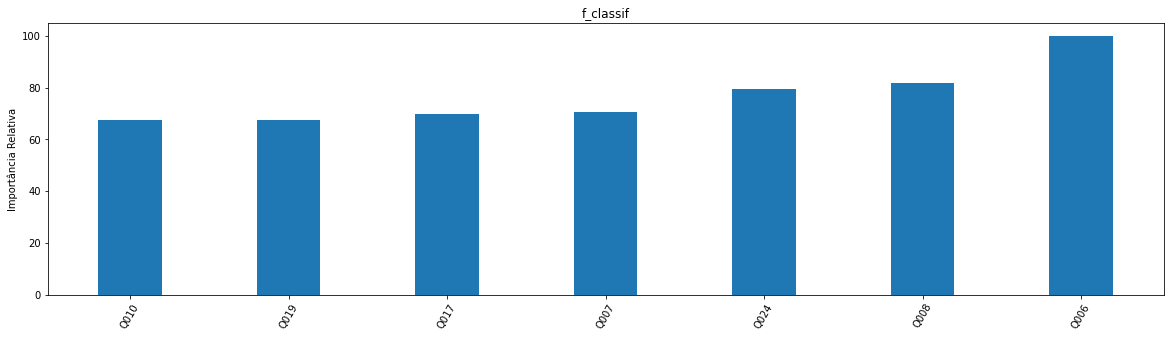

In [ ]:
# mutual_info_classif
# Mutual information for a discrete target.

# chi2
# Chi-squared stats of non-negative features for classification tasks.

# f_regression
# F-value between label/feature for regression tasks.

# mutual_info_regression
# Mutual information for a continuous target.

methods = [f_classif]
plot_att_importance(methods, x_param)

Com o uso dos três métodos, chegamos às variáveis que mais influenciam as notas dos alunos que prestaram o teste. Dessa forma, podemos descartar as outras variáveis em uma próxima etapa de treinamento.

In [ ]:
top_sig = zero_sig.copy()
drop_list = ["Q006", "Q024", "Q008", "Q007","Q017", "Q019", "Q010"]
top_sig = top_sig.drop(top_sig.columns.difference(drop_list), axis=1)
top_sig['NOTA_ENEM'] = array_y
top_sig

,Q006,Q007,Q008,Q010,Q017,Q019,Q024,NOTA_ENEM
0,0.0625,0.0,0.50,0.00,0.0,0.00,0.25,0.549675
1,0.0625,0.0,0.25,0.00,0.0,0.25,0.00,0.284479
2,0.1250,0.0,0.25,0.00,0.0,0.25,0.00,0.564468
3,0.0625,0.0,0.25,0.00,0.0,0.25,0.00,0.613746
4,0.2500,0.0,0.25,0.25,0.0,0.25,0.00,0.673255
...,...,...,...,...,...,...,...,...
127375,0.3750,0.0,0.50,0.00,0.0,0.25,0.25,0.688600
127376,0.0625,0.0,0.25,0.00,0.0,0.25,0.25,0.532768
127377,0.0625,0.0,0.25,0.00,0.0,0.00,0.00,0.349151
127378,0.1250,0.0,0.25,0.00,0.0,0.25,0.00,0.618117


## Exportando os resultados

In [ ]:
top_sig.to_csv('enem_dados.csv')

## E as respostas?

Relembrando as questões:
1. Qual a região que teve o melhor e o pior desempenho?
2. Qual a faixa etária teve o melhor e o pior desempenho?
3. Qual o quantitativo de pessoas que possui algum tipo de deficiência?
4. Quem zerou uma prova faltou ou teve desempenho ruim?
5. Há algum fator no questionário que tenha impactado na nota do candidato?

Deixamos nosso dataset *aparentemente* limpo, discretizado e normalizado. Neste ponto, as informações normalizadas não fazem muito sentido para nós, uma vez que eles possuem valores entre 0 e 1. E o que isso significa? 

Bem, significa que para um modelo de ML ele está pronto para ser utilizado. Porém, para este nosso exemplo, há 4 das 5 questões que não requerem um dataset normalizado.

É por isso que, ao longo do documento, montamos alguns datasets, armazenando os resultados modificados em dataframes a cada etapa para montar uma espécie de **Data Lake**.

Vamos utilizar o dataset **df_ds**, que foi criado antes de termos os dados normalizados.

In [ ]:
df_com_nota = df_ds.copy()
df_com_nota['NOTA_ENEM'] = array_y

### 1. Qual a região que teve o melhor e o pior desempenho?

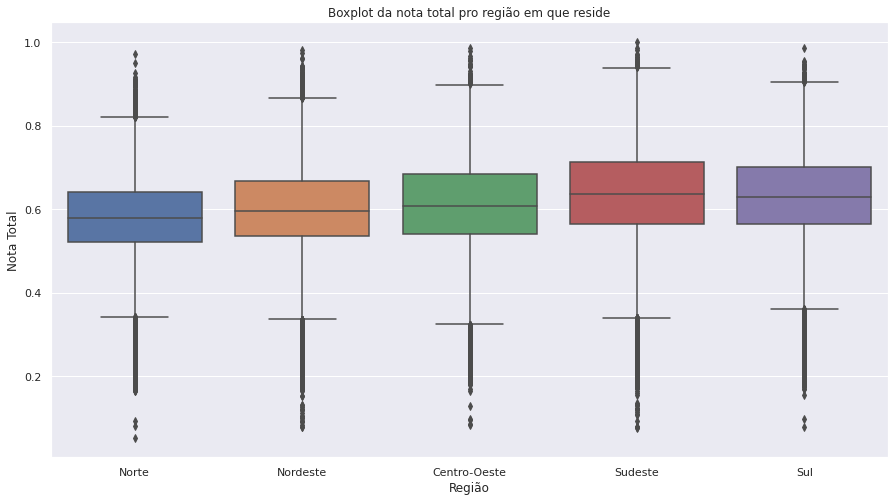

In [ ]:
df_r = df_com_nota.query("NOTA_ENEM != 0")
regioes_ordenadas = regioes.keys()
plt.figure(figsize=(15, 8))
sns.set()
ax = sns.boxplot(x="TP_REGIAO", y = "NOTA_ENEM", data = df_r)
ax.set_xlabel('Região')
ax.set_xticklabels(list(regioes.keys()))
ax.set_ylabel('Nota Total')
ax.set_title("Boxplot da nota total pro região em que reside")
plt.show()

### 2. Qual a faixa etária teve o melhor e o pior desempenho?

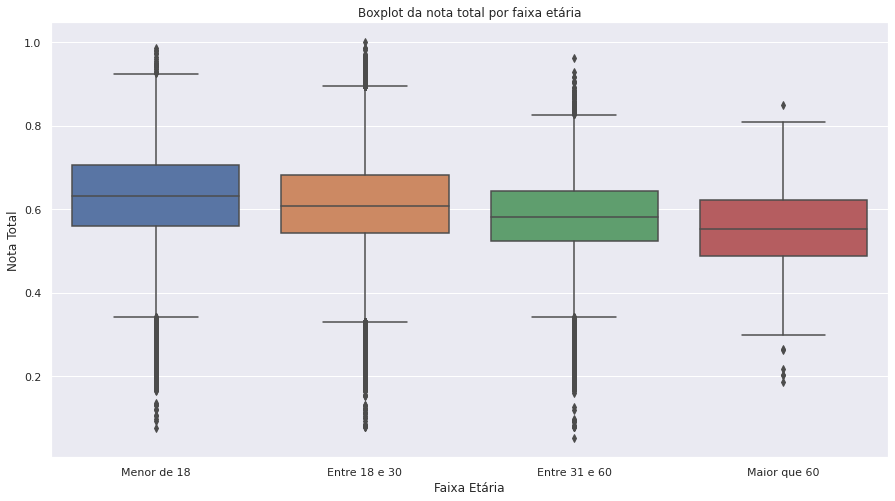

In [ ]:
df_f = df_com_nota.query("NOTA_ENEM != 0")
plt.figure(figsize=(15, 8))
sns.set()
ax = sns.boxplot(x="TP_FAIXA_ETARIA", y = "NOTA_ENEM", data = df_f)
ax.set_xlabel('Faixa Etária')
ax.set_xticklabels(list(faixas.values()))
ax.set_ylabel('Nota Total')
ax.set_title("Boxplot da nota total por faixa etária")
plt.show()

### 3. Qual o quantitativo de pessoas que possui algum tipo de deficiência?

In [ ]:
df_com_nota[df_com_nota['TP_PCD'] == 1]

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_PROVA,SG_UF_RESIDENCIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,TP_SEXO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NOTA_ENEM
201,190001012181,2019,Belém,PA,1,3,1,1,2,0,0,436.5,505.5,503.1,400.2,640.0,1,1,3,1,2,3,3,2,5,2,1,2,2,1,1,2,1,1,1,1,1,1,2,1,1,2,1,1,2,0.596840
399,190001020083,2019,Itaituba,PA,1,1,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,5,5,3,6,4,3,1,2,3,1,1,2,1,1,1,1,1,1,2,2,1,3,1,2,2,0.000000
434,190001021060,2019,Benevides,PA,1,3,1,1,1,0,0,344.7,484.0,377.7,390.1,460.0,1,1,3,1,2,3,1,2,6,3,1,2,3,1,2,2,1,2,1,1,1,1,2,1,1,3,1,1,1,0.493864
1005,190001043627,2019,Boa Vista,RR,2,3,1,1,1,0,0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,2,5,1,1,2,2,1,2,3,1,2,2,1,1,1,1,1,1,2,1,1,2,1,1,1,0.000000
1302,190001055170,2019,Tucuruí,PA,1,1,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,5,2,2,5,2,1,2,3,1,1,2,1,1,1,1,1,1,2,1,1,3,1,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126451,190006063178,2019,Rio de Janeiro,RJ,4,2,1,1,1,0,0,404.7,531.4,403.2,388.1,240.0,1,2,3,4,8,8,6,2,2,3,1,2,2,1,1,2,2,2,1,2,1,1,2,1,1,3,1,2,2,0.472467
126865,190006079969,2019,Feira de Santana,BA,1,3,1,1,1,0,1,393.9,451.5,544.9,373.0,600.0,1,0,3,2,5,7,6,4,3,11,4,5,4,2,1,2,2,2,1,2,1,2,4,1,2,4,2,2,2,0.567542
126890,190006080894,2019,Macaé,RJ,1,1,1,0,1,0,0,568.5,668.6,624.9,751.3,760.0,1,1,3,4,5,6,3,4,3,7,1,3,4,2,1,2,2,2,1,2,1,1,2,1,2,4,2,3,2,0.810091
126925,190006082323,2019,Brasília,DF,1,3,1,1,1,0,0,369.2,419.8,407.8,501.5,180.0,1,1,3,3,5,7,4,4,5,14,1,4,5,3,1,2,1,2,1,2,1,2,2,1,1,4,2,3,2,0.451070


### 4. Quem zerou uma prova faltou ou teve desempenho ruim?

In [ ]:
presencas

In [ ]:
df_nota_zero = df_com_nota.query("NOTA_ENEM == 0")
dados = round(df_nota_zero['TP_PRESENCA'].value_counts(normalize=True) * 100, 2)
d_dados = {}
for i in presencas:
  d_dados[presencas[i]] = f"{dados[i]}%"
d_dados

{'Nenhum dia': '99.44%',
 'Somente dia 1': '0.13%',
 'Somente dia 2': '0.01%',
 'Todos os dias': '0.42%'}

### 5. Há algum fator no questionário que tenha impactado na nota do candidato?

Na seção **Verificando a importância das colunas**, utilizamos três métodos para encontrar quais variáveis de nossa base mais influenciam na nota dos alunos participantes do ENEM. Abaixo seguem os gráficos referentes aos resultados dos métodos utilizados:

In [ ]:
plot_att_importance(methods, x_param)

Como podemos observar, há uma predominância entre variáveis que mais influenciam no resultado, sendo estas:

* Q006: Qual é a renda mensal de sua família?
* Q007: Em sua residência trabalha empregado(a) doméstico(a)?
* Q008: Na sua residência tem banheiro?
* Q010: Na sua residência tem carro?
* Q017: Na sua residência tem máquina de lavar louça? 
* Q019: Na sua residência tem televisão em cores?
* Q024: Na sua residência tem computador?


## Treinando um modelo

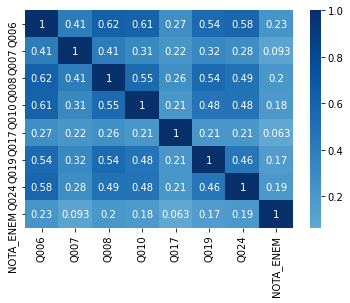

In [ ]:
correlacao = top_sig.corr()
sns.heatmap(correlacao, cmap="Blues", center=0, annot=True)

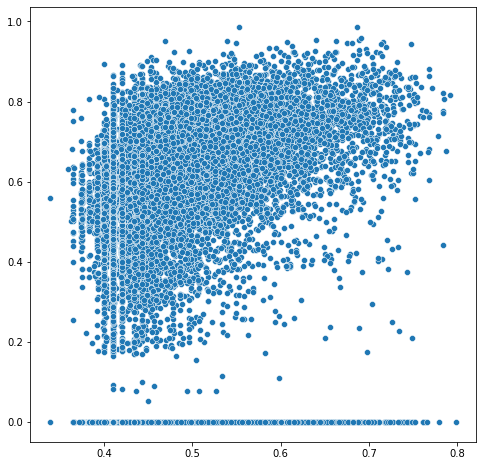

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

array_n = top_sig.values
X = array_n[:, 0:len(top_sig.columns)-1]
Y = array_n[:, -1]

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.20,random_state=1)
# modelo = LinearSVR(random_state = 1)
# modelo.fit(x_treino, y_treino)
# y_pred = modelo.predict(x_teste)

regressor = LinearRegression()
regressor.fit(x_treino, y_treino)
y_pred = regressor.predict(x_teste)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_pred, y=y_teste)

## Classificando registros

In [ ]:
df_class = df_norm.drop(['NOTA_ENEM', 'NU_INSCRICAO', 'NU_ANO'], axis=1)
df_class

,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,TP_SEXO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,0.25,0.6,0.25,1.0,0.0,0.0,1.0,0.546344,0.632938,0.609455,0.438985,0.42,0.0,0.000000,1.000000,0.00,0.142857,0.142857,0.0,0.0,0.157895,0.0625,0.0,0.50,0.25,0.00,0.50,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.0,0.0,0.50,0.0,0.25,1.0
1,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.505683,0.468130,0.000000,0.40,0.0,0.333333,0.333333,0.00,0.285714,0.285714,0.0,0.0,0.157895,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.25,0.25,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0
2,0.50,0.2,0.25,1.0,0.0,0.0,0.0,0.530791,0.616630,0.550081,0.433706,0.56,0.0,0.666667,1.000000,0.00,0.285714,0.000000,0.2,0.2,0.210526,0.1250,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.25,0.00,0.0,0.0,0.0,0.25,0.0,1.0,0.25,0.0,0.00,1.0
3,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.534554,0.714233,0.687913,0.507513,0.50,0.0,0.333333,1.000000,0.00,0.571429,0.285714,0.0,0.0,0.000000,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0
4,0.25,0.6,0.25,0.0,0.0,0.0,1.0,0.647811,0.705831,0.637645,0.430964,0.78,0.0,0.000000,1.000000,0.00,0.571429,0.571429,0.2,0.6,0.105263,0.2500,0.0,0.25,0.50,0.25,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,0.25,0.2,0.25,1.0,0.5,0.0,0.0,0.630127,0.691376,0.655732,0.547919,0.74,0.0,0.000000,1.000000,0.75,0.428571,0.714286,0.0,0.6,0.105263,0.3750,0.0,0.50,0.50,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0
127376,0.25,0.4,0.25,0.0,0.5,0.0,0.0,0.563276,0.470596,0.561681,0.424569,0.52,0.0,0.333333,1.000000,0.25,0.571429,0.285714,0.0,0.2,0.157895,0.0625,0.0,0.25,0.50,0.00,0.25,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0
127377,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.637509,0.621055,0.000000,0.44,0.0,0.333333,0.333333,0.25,1.000000,0.571429,1.0,0.2,0.000000,0.0625,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.25,0.0,0.00,1.0
127378,0.50,0.4,0.25,1.0,0.0,0.0,0.0,0.708265,0.514208,0.645254,0.462640,0.62,0.0,0.333333,1.000000,0.25,0.571429,0.571429,0.4,0.2,0.052632,0.1250,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0


In [ ]:
from sklearn.decomposition import PCA 
pca = PCA(2)  
projected = pca.fit_transform(df_class)
print(df_class.shape)
print(projected.shape)

(127380, 41)
(127380, 2)


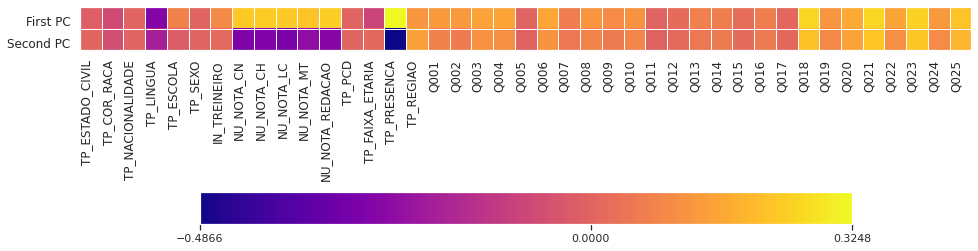

In [ ]:
fig = plt.figure(figsize=(20, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(df_class.columns)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65,);

Verificando o número de clusters (classes a serem geradas a partir da aplicação do algoritmo)

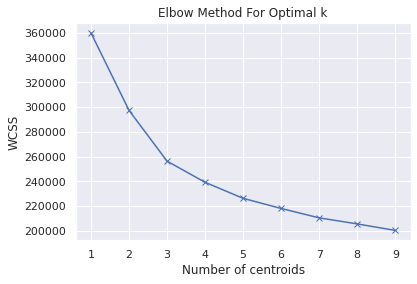

In [ ]:
wcss = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(np.array(df_class[:]))
    wcss.append(km.inertia_)

plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

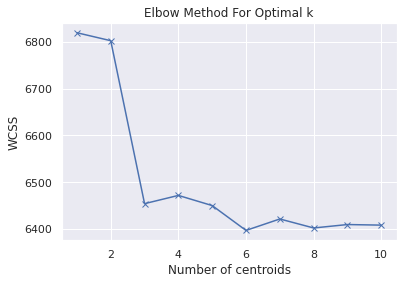

In [ ]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

sse = calculate_WSS(np.array(df_class[:]), 10)

plt.plot(range(1,11), sse, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

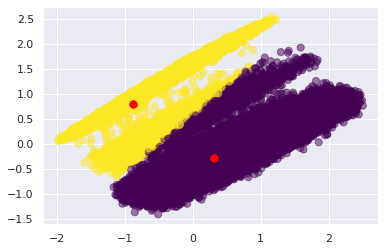

In [ ]:
df = pd.DataFrame(projected, columns=['PCA1', 'PCA2'])

kmeans = KMeans(n_clusters=2, random_state=0).fit(df)
y_kmeans = kmeans.predict(df)
plt.scatter(df['PCA1'], df['PCA2'], c=y_kmeans, s=50, alpha=0.5,cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
plt.show()

In [ ]:
df_norm['TP_CLASSE'] = kmeans.labels_
df_norm

,NU_INSCRICAO,NU_ANO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_LINGUA,TP_ESCOLA,TP_SEXO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_PCD,TP_FAIXA_ETARIA,TP_PRESENCA,TP_REGIAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NOTA_ENEM,TP_CLASSE
0,0.000000,0.0,0.25,0.6,0.25,1.0,0.0,0.0,1.0,0.546344,0.632938,0.609455,0.438985,0.42,0.0,0.000000,1.000000,0.00,0.142857,0.142857,0.0,0.0,0.157895,0.0625,0.0,0.50,0.25,0.00,0.50,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.0,0.0,0.50,0.0,0.25,1.0,0.549675,1
1,0.000003,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.505683,0.468130,0.000000,0.40,0.0,0.333333,0.333333,0.00,0.285714,0.285714,0.0,0.0,0.157895,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.25,0.25,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.284479,2
2,0.000012,0.0,0.50,0.2,0.25,1.0,0.0,0.0,0.0,0.530791,0.616630,0.550081,0.433706,0.56,0.0,0.666667,1.000000,0.00,0.285714,0.000000,0.2,0.2,0.210526,0.1250,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.25,0.00,0.0,0.0,0.0,0.25,0.0,1.0,0.25,0.0,0.00,1.0,0.564468,1
3,0.000014,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.534554,0.714233,0.687913,0.507513,0.50,0.0,0.333333,1.000000,0.00,0.571429,0.285714,0.0,0.0,0.000000,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,1.0,0.613746,1
4,0.000022,0.0,0.25,0.6,0.25,0.0,0.0,0.0,1.0,0.647811,0.705831,0.637645,0.430964,0.78,0.0,0.000000,1.000000,0.00,0.571429,0.571429,0.2,0.6,0.105263,0.2500,0.0,0.25,0.50,0.25,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.00,1.0,0.673255,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127375,0.999974,0.0,0.25,0.2,0.25,1.0,0.5,0.0,0.0,0.630127,0.691376,0.655732,0.547919,0.74,0.0,0.000000,1.000000,0.75,0.428571,0.714286,0.0,0.6,0.105263,0.3750,0.0,0.50,0.50,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.688600,1
127376,0.999974,0.0,0.25,0.4,0.25,0.0,0.5,0.0,0.0,0.563276,0.470596,0.561681,0.424569,0.52,0.0,0.333333,1.000000,0.25,0.571429,0.285714,0.0,0.2,0.157895,0.0625,0.0,0.25,0.50,0.00,0.25,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0,0.532768,1
127377,0.999974,0.0,0.25,0.6,0.25,1.0,0.0,0.0,0.0,0.000000,0.637509,0.621055,0.000000,0.44,0.0,0.333333,0.333333,0.25,1.000000,0.571429,1.0,0.2,0.000000,0.0625,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.25,0.0,0.00,1.0,0.349151,1
127378,0.999978,0.0,0.50,0.4,0.25,1.0,0.0,0.0,0.0,0.708265,0.514208,0.645254,0.462640,0.62,0.0,0.333333,1.000000,0.25,0.571429,0.571429,0.4,0.2,0.052632,0.1250,0.0,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0,0.618117,1
